In [1]:
import os
import datetime

import numpy as np
import pandas as pd

from pyproj import Transformer
import geopandas as gpd
from shapely.geometry import Point
import movingpandas as mpd

import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")
import seaborn as sns

import folium as fl
from folium.plugins import FastMarkerCluster

In [2]:
data = pd.read_csv("./data/france_data/AIS_Data/nari_dynamic.csv")
static = pd.read_csv("./data/france_data/AIS_Data/nari_static.csv")

data.sort_values(by=["sourcemmsi", "t"], inplace=True)
data["BaseDateTime"] = pd.to_datetime(data["t"], unit="s")
data.reset_index(drop=True, inplace=True)

C:\Users\rendr\AppData\Local\Temp\ipykernel_30976\4023312744.py:2: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv("./data/france_data/AIS_Data/nari_static.csv")


In [3]:
data.drop(columns="t", inplace=True)

In [4]:
data.columns = ["MMSI", "Status", "ROT", "SOG", "COG", "Heading", "LON", "LAT", "BaseDateTime"]

In [5]:
data = data[["BaseDateTime", "MMSI", "LAT", "LON", "SOG", "COG", "Status"]]

In [6]:
data.head()

BaseDateTime     MMSI        LAT       LON   SOG    COG  Status
0 2015-12-01 13:38:49   923166  50.339893 -4.145470   9.1  256.9     0.0
1 2015-12-01 13:43:39   923166  50.334972 -4.166038  10.8  227.6     0.0
2 2015-12-01 17:43:21   923166  50.336380 -4.161366   8.9   84.2     0.0
3 2015-10-14 07:33:28  1234500  47.833645 -4.173160   0.0  305.7     8.0
4 2016-03-21 15:48:20  9105765  48.091164 -4.337853   0.2  253.1     NaN

In [7]:
static = static[["sourcemmsi", "shiptype"]]
static.columns = ["MMSI", "VesselType"]

In [8]:
static = static.groupby(["MMSI", "VesselType"]).size().reset_index().drop(columns=0)

In [9]:
static.head()

MMSI  VesselType
0      1178        54.0
1      2383        51.0
2     11603         0.0
3   1234500        30.0
4  37100300        52.0

In [10]:
ports = gpd.read_file("./data/france_data/Ports_Brittany/port.shp")

In [11]:
ports = ports[["libelle_po", "por_x", "por_y", "geometry"]]
ports.columns = ["Name", "X", "Y", "geometry"]

In [12]:
ports.head()

Name         X          Y                        geometry
0       Le Vivier-sur-Mer  297025.0  2408370.0  MULTIPOINT (-1.77180 48.60274)
1  Saint-Samson sur Rance  279335.0  2396060.0  MULTIPOINT (-2.00199 48.48370)
2              Douarnenez  103135.0  2365330.0  MULTIPOINT (-4.34120 48.09710)
3               Brézellec   79105.4  2364190.0  MULTIPOINT (-4.66112 48.06804)
4                    Sein   64562.5  2362180.0  MULTIPOINT (-4.85294 48.03825)

# Clean Data

In [13]:
# get brest port coordinates
brest_port = ports[ports["Name"] == "Brest"]
lon = brest_port.iloc[0]["geometry"].geoms[0].xy[0][0]
lat = brest_port.iloc[0]["geometry"].geoms[0].xy[1][0]

# get port near brest port coordinates
near_brest_port = ports.loc[208]
lon_near = near_brest_port["geometry"].geoms[0].xy[0][0]
lat_near = near_brest_port["geometry"].geoms[0].xy[1][0]

In [14]:
# filter cargo vessels
cargo_vessels = static.loc[(static["VesselType"] >= 70)
                           & (static["VesselType"] <= 79), "MMSI"].unique()
data_cargo = data[data["MMSI"].isin(cargo_vessels)]

In [15]:
# Get the distance of each point to the port (defined by the quay point)
transformer = Transformer.from_crs(4326, 3857)
x, y = transformer.transform(data_cargo["LAT"].to_numpy(), data_cargo["LON"].to_numpy())
data_cargo["x"] = x
data_cargo["y"] = y
quay_point = Point(transformer.transform(lat, lon-0.01))
distanceToPort = gpd.points_from_xy(data_cargo.x, data_cargo.y, crs=3857)\
    .distance(quay_point)
data_cargo["distanceToPort"] = distanceToPort

C:\Users\rendr\AppData\Local\Temp\ipykernel_30976\599828321.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cargo["x"] = x
C:\Users\rendr\AppData\Local\Temp\ipykernel_30976\599828321.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cargo["y"] = y
C:\Users\rendr\AppData\Local\Temp\ipykernel_30976\599828321.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [16]:
# filter vessels arriving at Port of Brest
data_cargo["brest_stopped_points"] = 0
data_cargo.loc[(data_cargo["Status"] == 5)
               & (data_cargo["SOG"] < 1)
               & (data_cargo["distanceToPort"] < 3500), "brest_stopped_points"] = 1
brest_cargo_vessels = data_cargo.loc[data_cargo["brest_stopped_points"] == 1,
                                    "MMSI"].unique()
data_cargo_brest = data_cargo.loc[data_cargo["MMSI"].isin(brest_cargo_vessels)]

C:\Users\rendr\AppData\Local\Temp\ipykernel_30976\271308073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cargo["brest_stopped_points"] = 0


In [17]:
brest_cargo_vessels.shape

(70,)

In [18]:
# Plot circle
m = fl.Map(location=[lat,lon], zoom_start=12)
fl.Marker(location=[lat,lon]).add_to(m)
fl.Marker(location=[lat_near,lon_near]).add_to(m)
fl.Circle(location=(lat,lon-0.01), radius=3500).add_to(m)
stopped_points = data_cargo_brest.loc[(data_cargo_brest["Status"] == 5)
                                      & (data_cargo_brest["SOG"] < 1.0), ["LAT", "LON"]]
fmc = FastMarkerCluster(data=stopped_points).add_to(m)
m

In [19]:
data_cargo_brest[["LAT", "LON", "SOG", "COG"]].describe()

LAT           LON           SOG           COG
count  1.083795e+06  1.083795e+06  1.083795e+06  1.083795e+06
mean   4.830867e+01 -4.594045e+00  4.650845e+00  1.909493e+02
std    1.134348e-01  2.191049e-01  7.228131e+00  1.084359e+02
min    4.560250e+01 -8.042987e+00  0.000000e+00  0.000000e+00
25%    4.827503e+01 -4.678488e+00  0.000000e+00  7.400000e+01
50%    4.836660e+01 -4.507965e+00  5.000000e-01  2.260000e+02
75%    4.838142e+01 -4.471815e+00  9.100000e+00  2.851000e+02
max    5.017789e+01 -1.377832e+00  1.023000e+02  3.600000e+02

C:\Users\rendr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rendr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


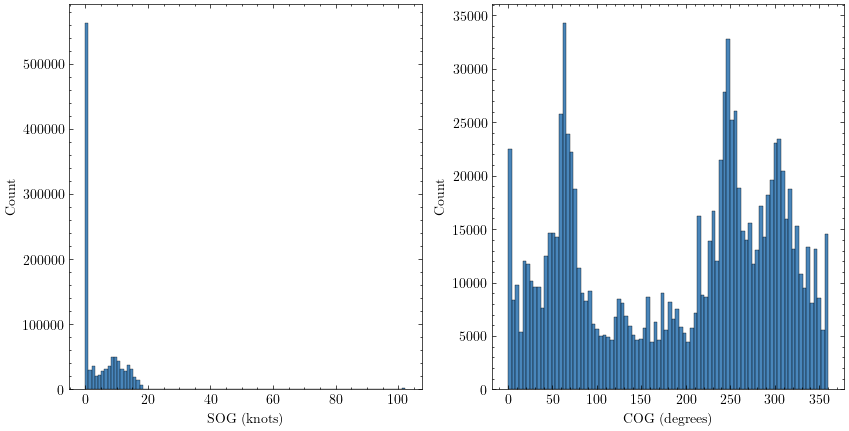

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
sns.histplot(data=data_cargo_brest, x="SOG", bins=100, ax=axs[0])
axs[0].set_xlabel("SOG (knots)")
sns.histplot(data=data_cargo_brest, x="COG", ax=axs[1])
axs[1].set_xlabel("COG (degrees)")
plt.savefig("./figures/france_data_hist")
plt.show()

In [21]:
data_cargo_brest = data_cargo_brest[data_cargo_brest["SOG"] < 102.3]
data_cargo_brest = data_cargo_brest[data_cargo_brest["COG"] < 360]
data_cargo_brest = data_cargo_brest[data_cargo_brest["Status"].isin([0, 1, 5])]

In [22]:
data_cargo_brest = data_cargo_brest[["BaseDateTime", "LAT", "LON", "SOG", "COG",
                                     "Status", "MMSI"]]
data_cargo_brest.columns = ["BaseDateTime", "LAT", "LON", "SOG", "COG",
                            "Status", "vessel"]

In [23]:
data_cargo_brest.sort_values(by=["vessel", "BaseDateTime"], inplace=True)

# Save Data

In [24]:
data_cargo_brest.head()

BaseDateTime        LAT       LON  SOG   COG  Status     vessel
51136 2015-12-16 09:31:35  48.381700 -4.471865  0.0  28.9     5.0  207138000
51137 2015-12-16 09:31:45  48.381706 -4.471863  0.0  33.6     5.0  207138000
51138 2015-12-16 09:31:54  48.381680 -4.471873  0.0  24.7     5.0  207138000
51139 2015-12-16 09:32:05  48.381653 -4.471885  0.0  30.0     5.0  207138000
51140 2015-12-16 09:32:15  48.381668 -4.471892  0.0  24.5     5.0  207138000

In [25]:
data_cargo_brest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1022297 entries, 51136 to 18647966
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   BaseDateTime  1022297 non-null  datetime64[ns]
 1   LAT           1022297 non-null  float64       
 2   LON           1022297 non-null  float64       
 3   SOG           1022297 non-null  float64       
 4   COG           1022297 non-null  float64       
 5   Status        1022297 non-null  float64       
 6   vessel        1022297 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 62.4 MB


In [26]:
data_cargo_brest.describe()

BaseDateTime           LAT           LON  \
count                        1022297  1.022297e+06  1.022297e+06   
mean   2015-12-31 21:15:50.373793792  4.831344e+01 -4.599604e+00   
min              2015-09-30 22:00:02  4.560250e+01 -8.042987e+00   
25%              2015-11-22 09:09:54  4.828210e+01 -4.690665e+00   
50%              2016-01-03 15:10:11  4.836727e+01 -4.512838e+00   
75%              2016-02-13 13:37:28  4.838142e+01 -4.471849e+00   
max              2016-03-31 21:59:29  5.017789e+01 -1.377832e+00   
std                              NaN  1.127800e-01  2.221326e-01   

                SOG           COG        Status        vessel  
count  1.022297e+06  1.022297e+06  1.022297e+06  1.022297e+06  
mean   4.501373e+00  1.886136e+02  1.119930e+00  3.144014e+08  
min    0.000000e+00  0.000000e+00  0.000000e+00  2.071380e+08  
25%    0.000000e+00  7.240000e+01  0.000000e+00  2.340560e+08  
50%    2.000000e-01  2.244000e+02  0.000000e+00  2.492970e+08  
75%    9.300000e+00  2.830000e+02  1.000000e+00  3.560710e+08  
max    1.022000e+02  3.599000e+02  5.000000e+00  6.360923e+08  
std    5.582987e+00  1.081107e+02  2.052921e+00  1.118704e+08

In [27]:
data_cargo_brest.to_csv("./data/1_france_data.csv", index=False)